In [4]:
# import pickle
# from pathlib import Path

# locations = pickle.load(open("EB5n2_SCT_locations.pickle", "rb"))
# sdge = pickle.load(open("EB5n2_SCT_sdge.pickle", "rb"))
# tissue = pickle.load(open("EB5n2_SCT_tissue.pickle", "rb"))

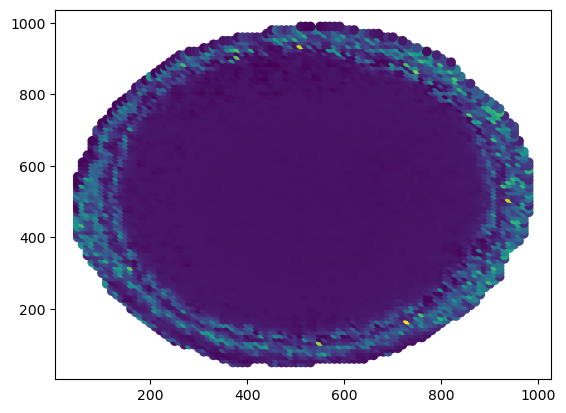

In [2]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# #sdge[1,]

# plt.scatter(locations[:,0], locations[:,1], c= sdge[50,])

In [3]:
# import pandas as pd
# df = pd.concat([pd.DataFrame(locations, columns= ["X", "Y"]), pd.DataFrame(sdge, index= tissue.gene_names).T], axis = 1)

In [7]:
# df.to_parquet("spatial_reconstruction.parquet",  compression="snappy")
# df.to_csv("spatial_reconstruction.csv")

## Saving Zarr and numpy arrays

In [ ]:
# import zarr
# import numpy as np

# zarr.save("sdge.zarr", sdge)
# np.save("locations.npy", locations)
# np.save("gene_names.npy", tissue.gene_names)

## Loading files, Init panel

CPU times: user 58.5 ms, sys: 55.8 ms, total: 114 ms
Wall time: 198 ms


MaterialTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] MaterialTemplateActions()
    [browser_info] BrowserInfo()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-140514348567088] Column
        [0] AutocompleteInput(name='Gene', options=['AL669831.5', ...], value='GAPDH')
        [1] HoloViews(Points, theme=<bokeh.themes.theme.Theme ...)
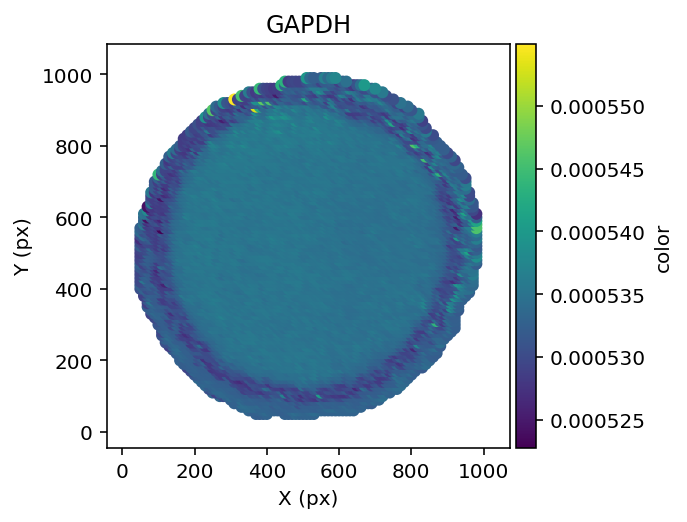

In [7]:
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
import zarr
import numpy as np
import base64
import holoviews as hv
import numpy as np
import panel as pn
import anndata
import scanpy


gene_names = np.load("gene_names.npy")
sdge = zarr.open("sdge.zarr")
locations = np.load("locations.npy")
EB5n2 = anndata.read("EB5n2.h5ad")

# Ensure holoviews is working with matplotlib
hv.extension('matplotlib')
pn.extension()


# Create an AutocompleteInput widget with a default value
gene_input = pn.widgets.AutocompleteInput(name='Gene', value='GAPDH', options=list(gene_names))


def plot_gene(gene: str):
    index = np.where(gene_names == gene)
    points = hv.Points((locations[:,0], locations[:, 1], sdge[index][0]),
    vdims=['Normalized gene expression']).opts(
    color='Normalized gene expression',
    cmap='viridis',
    colorbar = True,
    fontscale=1.5,
    fig_inches=3.5,
    fig_bounds=(0, 0, 1, 1),
    )

    points = points.redim.default(x=0, y=0).opts(title=gene, xlabel="X (px)", ylabel="Y (px)")
    return points

# Define a function that updates the plot when the TextInput value changes
def update_plot(event):
    plot = plot_gene(gene_input.value)
    plot_pane.object = plot

# Create a Markdown pane to display the link
link_pane = pn.pane.Markdown('')

# Define a function that will be called when the button is clicked
def save_plot(event):

    plot = plot_gene(gene_input.value)
    filename = 'plot.png'
    hv.save(plot, filename, dpi = 300)
    # Load the image and encode it using base64

    with open(filename, 'rb') as f:
        img_data = base64.b64encode(f.read()).decode("ascii")
    # Update the link pane
    link_pane.object = f'<a href="data:image/png;base64,{img_data}" target="_blank">Right click - open in a new tab/window</a>'
    

save_button = pn.widgets.Button(name='Save', button_type='primary')
save_button.on_click(save_plot)


# Create a Pane to display the plot
plot_pane = pn.pane.HoloViews()

# Call the update function whenever the TextInput value changes
gene_input.param.watch(update_plot, 'value')

# Initialize the plot
update_plot(None)

# Create a Panel layout with the TextInput and the plot
layout = pn.Column(gene_input, save_button, link_pane, plot_pane)

# Create a Panel template with a title
template = pn.template.MaterialTemplate(title='Spatial reconstruction')

# Add the layout to the main area of the template
template.main.append(layout)

# Display the template
template.servable()

